# Jan 31st, 2022 (centroid thresh)

**Motivation**: Thresholding centroids and its effect on the proportion figure.  <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def plot_df_se(df, title=None, bbox_to_anchor=(1.07, 0.55)):
    fg = sns.catplot(
        data=df,
        x='oc_idx',
        y='SE',
        hue='label',
        col='bin_idx',
        col_wrap=2,
        kind='point',
        height=3.5,
        ci=None,
    )
    for ax in fg.axes.flat:
        ax.grid(ls=':')
        ax.set_title(ax.get_title(), fontsize=13)
        ax.set_xlabel(ax.xaxis.get_label().get_text(), fontsize=13)
        ax.set_ylabel(ax.yaxis.get_label().get_text(), fontsize=13)

    plt.setp(fg.legend, bbox_to_anchor=bbox_to_anchor)
    for text in fg.legend.get_texts():
        plt.setp(text, fontsize=14)
    fg.legend.set_title(title)
    plt.setp(fg.legend.get_title(), fontsize=15)
    plt.show()
    
    return fg

## Prepare

In [3]:
mice = Mice((128, 0, 100))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

In [4]:
props_base = {
    'num_k': 5,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'perc': 'p20-sample', **props_base}
props_bold = {'perc': 'p20-sample', **props_base}

gr_ca = Group(mode='ca2', centroids_from='runs', **props_ca).fit_group()
gr_bold = Group(mode='bold-lite', centroids_from='runs', **props_bold).fit_group()

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi,
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()

## Membership plot

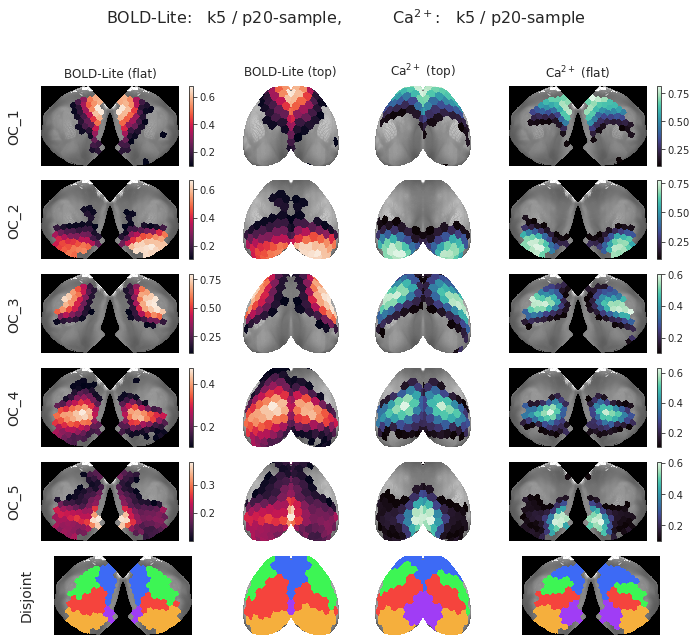

In [5]:
fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

In [6]:
gr_bold.pi_symmetry_score(decimals=5)

(
    {1: 0.99524, 2: 0.99079, 3: 0.98515, 4: 0.96904, 5: 0.99135, -1: 0.98631},
    {1: 0.97701, 2: 0.94253, 3: 0.94253, 4: 0.87356, 5: 0.98851, -1: 0.94483}
)

In [7]:
gr_ca.pi_symmetry_score(decimals=5)

(
    {1: 0.98899, 2: 0.9926, 3: 0.97097, 4: 0.99012, 5: 0.99235, -1: 0.98701},
    {1: 0.91954, 2: 0.97701, 3: 0.88506, 4: 0.93103, 5: 0.98851, -1: 0.94023}
)

## Boot

### Centroids; no threshold

In [59]:
pi_bold = pi_from_gam(gr_bold.run_centroids)
pi_anim = bn.nanmean(bn.nanmean(pi_bold, 2), 1)
pi_bold.shape, pi_anim.shape

((10, 3, 4, 5, 174), (10, 5, 174))

In [60]:
%%time

dims = {'sub': 10, 'ses': 3, 'run': 4}

b_grp = bootstrap(
    x=pi_bold,
    n_resamples=20000,
    batch=5,
    dims=dims,
    est=None,
)
b_grp_avg = bn.nanmean(bn.nanmean(bn.nanmean(b_grp, 3), 2), 1)

b_anim = bootstrap(
    x=pi_bold,
    n_resamples=20000,
    batch=5,
    skip=['sub'],
    dims=dims,
    est=None,
)
b_anim_avg = bn.nanmean(bn.nanmean(b_anim, 3), 2)

b_grp_avg.shape, b_anim_avg.shape

CPU times: user 21.2 s, sys: 2min 8s, total: 2min 29s
Wall time: 2min 31s


((20000, 5, 174), (20000, 10, 5, 174))

In [64]:
se_grp = np.nanstd(b_grp_avg, axis=0, ddof=1)
se_anim = np.nanstd(b_anim_avg, axis=0, ddof=1)

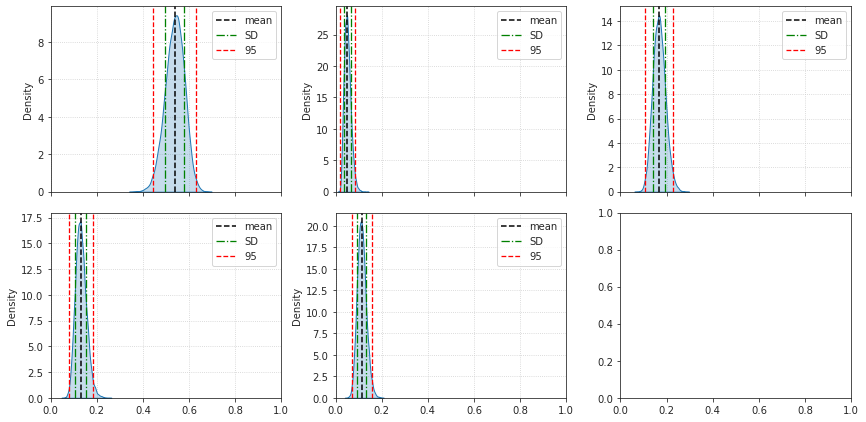

In [65]:
kk = 0
nn = 13

ci = 0.95
dof = 11
t_val = sp_stats.t.ppf((1 + ci) / 2, dof)

means = []
fig, axes = create_figure(2, 3, (12, 6), 'all')
for kk in range(5):
    ax = axes.flat[kk]
    mu, sd = bn.nanmean(b_grp_avg[:, kk, nn]), np.nanstd(b_grp_avg[:, kk, nn], ddof=1)
    means.append(mu)

    sns.kdeplot(b_grp_avg[:, kk, nn], fill=True, ax=ax)
    ax.axvline(mu, ls='--', color='k', label='mean')
    ax.axvline(mu - sd, ls='-.', color='g', lw=1.3, label='SD')
    ax.axvline(mu + sd, ls='-.', color='g', lw=1.3)
    
    ax.axvline(mu - t_val * sd, ls='--', color='r', lw=1.3, label=f"ci={ci:0.2f}")
    ax.axvline(mu + t_val * sd, ls='--', color='r', lw=1.3)
    
    ax.set_xlim(0, 1)
    ax.legend()
    ax.grid()
# trim_axs(axes, 5)
plt.show()

In [125]:
thres = 0.0

ci = 0.99
dof = 11
t_val = sp_stats.t.ppf(ci, dof)
t_val, thres

(2.7180791835355564, 0.0)

In [126]:
save_dir = pjoin(tmp_dir, f'Node_Boot_{ci}')
os.makedirs(save_dir, exist_ok=True)

In [127]:
for nn in tqdm(gr_bold.n2l):
    votes = np.zeros((10, 5))
    for anim in range(10):
        for kk in range(5):
            mu = pi_anim[anim, kk, nn]
            se = se_anim[anim, kk, nn]
            if mu - t_val * se <= thres:
                votes[anim, kk] = 1
    votes_portion = votes.mean(0)
    votes_majority = votes_portion > 0.5

    fig, axes = create_figure(10, 5, (13, 24), 'all')
    for anim in range(10):
        for kk in range(5):
            ax = axes[anim, kk]

            mu = pi_anim[anim, kk, nn]
            se = se_anim[anim, kk, nn]

            sns.kdeplot(b_anim_avg[:, anim, kk, nn], fill=True, ax=ax)
            ax.axvline(mu, ls='--', color='k', label='mean')
            ax.axvline(mu - t_val * se, ls='--', color='r', lw=1.3, label=f"ci={ci:0.2f}")
            ax.axvline(mu + t_val * se, ls='--', color='r', lw=1.3)

            ax.set_xlim(0, 1)
            ax.grid()

            if anim == 0:
                msg = f"OC_{kk + 1}\n("
                msg += 'reject' if votes_majority[kk] else 'accept'
                msg += f": {votes_portion[kk]:0.2f})\n\n"
            else:
                msg = ''
            msg += f"lower: {mu - t_val * se:0.2f}"
            ax.set_title(msg, fontsize=13)

            if kk == 4:
                ax.legend()

            if kk == 0:
                ax.set_ylabel(f"{mice.get_key(anim + 1)}", fontsize=12, labelpad=10)
            else:
                ax.set_ylabel('')

    sup = fig.suptitle(f"Node # {nn + 1}", fontsize=17, y=1.015)
    fig.savefig(pjoin(save_dir, f"bold-lite_node{nn+1:03d}.pdf"), bbox_inches='tight')
    plt.close()

  0%|          | 0/174 [00:00<?, ?it/s]

In [30]:
k, n = b.shape[-2:]
cut, _ = cut_data(
    data=b.reshape(-1, k, n),
    bins=gr_bold.bins,
    oc_only=True,
)
cut = cut.reshape((*b.shape[:-2], k, -1))
cut.shape

(1000, 10, 3, 4, 5, 4)

In [31]:
cut_avg = bn.nanmean(bn.nanmean(bn.nanmean(cut, 3), 2), 1)
cut_avg.shape

(1000, 5, 4)

In [32]:
np.nanmean(cut_avg, 0)

array([[35.35257269, 24.25489799, 18.78960105, 21.60292827],
       [31.60505511, 23.205275  , 23.96690542, 21.22276448],
       [28.94195561, 19.42095477, 19.71608786, 31.92100176],
       [42.74773016, 29.43862509, 20.66705075,  7.14659399],
       [46.02433307, 23.7929038 , 20.72464347,  9.45811967]])

In [33]:
gr_bold.grp_cut

memmap([[35.25878693, 24.28579604, 18.84041316, 21.61500387],
        [31.49803327, 23.17122317, 24.00660292, 21.32414064],
        [28.9771541 , 19.50553565, 19.69573704, 31.8215732 ],
        [42.91457401, 29.34498867, 20.56416208,  7.17627524],
        [45.9183388 , 23.75434539, 20.76910568,  9.55821013]])

In [34]:
np.nanstd(cut_avg, 0, ddof=1)

array([[2.23006038, 1.80892416, 1.2541704 , 3.08520803],
       [2.07948807, 1.76397168, 1.85827733, 3.3279419 ],
       [1.95293804, 1.64334958, 1.47204107, 3.2256078 ],
       [2.08587093, 1.4222766 , 1.82057903, 1.54422556],
       [3.075223  , 1.71320115, 1.77817119, 2.10455316]])

### Centroids; threshold at 0.1

In [35]:
pi_bold = pi_from_gam(gr_bold.run_centroids)
pi_bold[pi_bold <= 0.1] = 0
pi_bold /= np.nansum(pi_bold, -2, keepdims=True)
pi_bold.shape

(10, 3, 4, 5, 174)

In [36]:
collections.Counter(np.round(pi_bold.sum(-2).flat, 4)).most_common()[:5]

[(1.0, 19692), (nan, 1), (nan, 1), (nan, 1), (nan, 1)]

In [37]:
dims = {'sub': 10, 'ses': 3, 'run': 4}

b = bootstrap(
    x=pi_bold,
    n_resamples=1000,
    batch=5,
    dims=dims,
    est=None,
)
b.shape

(1000, 10, 3, 4, 5, 174)

In [38]:
tmp = np.round(b.sum(-2), 4)
tmp[np.isnan(tmp)] = -1

In [39]:
collections.Counter(tmp.flat).most_common()[:5]

[(1.0, 19697200), (-1.0, 1182800)]

In [40]:
b_pi = bn.nanmean(bn.nanmean(bn.nanmean(b, 3), 2), 1)
b_pi.shape

(1000, 5, 174)

In [41]:
collections.Counter(np.round(b_pi.sum(-2), 5).flat)

Counter({1.0: 174000})

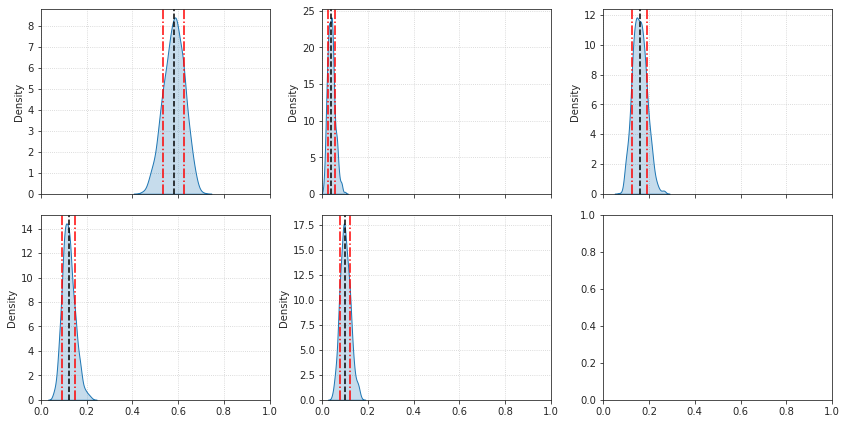

In [42]:
i, j, k = 3, 1, 2
kk = 0
nn = 13

means = []

fig, axes = create_figure(2, 3, (12, 6), 'all')
for kk in range(5):
    ax = axes.flat[kk]
    mu, sd = bn.nanmean(b_pi[:, kk, nn]), np.nanstd(b_pi[:, kk, nn], ddof=1)
    means.append(mu)

    sns.kdeplot(b_pi[:, kk, nn], fill=True, ax=ax)
    ax.axvline(mu, ls='--', color='k')
    ax.axvline(mu - sd, ls='-.', color='r')
    ax.axvline(mu + sd, ls='-.', color='r')
    ax.set_xlim(0, 1)
    ax.grid()
# trim_axs(axes, 5)
plt.show()

In [43]:
k, n = b.shape[-2:]
cut, _ = cut_data(
    data=b.reshape(-1, k, n),
    bins=gr_bold.bins,
    oc_only=True,
)
cut = cut.reshape((*b.shape[:-2], k, -1))
cut.shape

(1000, 10, 3, 4, 5, 4)

In [44]:
cut_avg = bn.nanmean(bn.nanmean(bn.nanmean(cut, 3), 2), 1)
cut_avg.shape

(1000, 5, 4)

In [45]:
np.nanmean(cut_avg, 0)

array([[33.46388336, 22.13439149, 17.53086845, 26.87085669],
       [30.27980922, 20.13193696, 21.12867589, 28.45957793],
       [28.22443005, 17.86373563, 17.1939181 , 36.71791622],
       [40.98436601, 26.42192578, 19.21558182, 13.37812639],
       [44.51958148, 22.67651605, 16.66216622, 16.14173625]])

In [46]:
gr_bold.grp_cut

memmap([[35.25878693, 24.28579604, 18.84041316, 21.61500387],
        [31.49803327, 23.17122317, 24.00660292, 21.32414064],
        [28.9771541 , 19.50553565, 19.69573704, 31.8215732 ],
        [42.91457401, 29.34498867, 20.56416208,  7.17627524],
        [45.9183388 , 23.75434539, 20.76910568,  9.55821013]])

In [47]:
np.nanstd(cut_avg, 0, ddof=1)

array([[2.07459299, 1.80024043, 1.21196305, 3.11188708],
       [1.93560472, 1.46622883, 1.46299661, 3.15573461],
       [1.91205078, 1.49135076, 1.21050489, 2.90172501],
       [2.07064463, 1.34313384, 1.35502178, 1.88315614],
       [3.07779654, 1.62534201, 1.2124867 , 2.25901199]])

### Centroids; threshold at 0.2

In [48]:
pi_bold = pi_from_gam(gr_bold.run_centroids)
pi_bold[pi_bold <= 0.2] = 0
pi_bold /= np.nansum(pi_bold, -2, keepdims=True)
pi_bold.shape

(10, 3, 4, 5, 174)

In [49]:
collections.Counter(np.round(pi_bold.sum(-2).flat, 4)).most_common()[:5]

[(1.0, 19692), (nan, 1), (nan, 1), (nan, 1), (nan, 1)]

In [50]:
dims = {'sub': 10, 'ses': 3, 'run': 4}

b = bootstrap(
    x=pi_bold,
    n_resamples=1000,
    batch=5,
    dims=dims,
    est=None,
)
b.shape

(1000, 10, 3, 4, 5, 174)

In [51]:
tmp = np.round(b.sum(-2), 4)
tmp[np.isnan(tmp)] = -1

In [52]:
collections.Counter(tmp.flat).most_common()[:5]

[(1.0, 19652515), (-1.0, 1227485)]

In [53]:
b_pi = bn.nanmean(bn.nanmean(bn.nanmean(b, 3), 2), 1)
b_pi.shape

(1000, 5, 174)

In [54]:
collections.Counter(np.round(b_pi.sum(-2), 5).flat)

Counter({1.0: 174000})

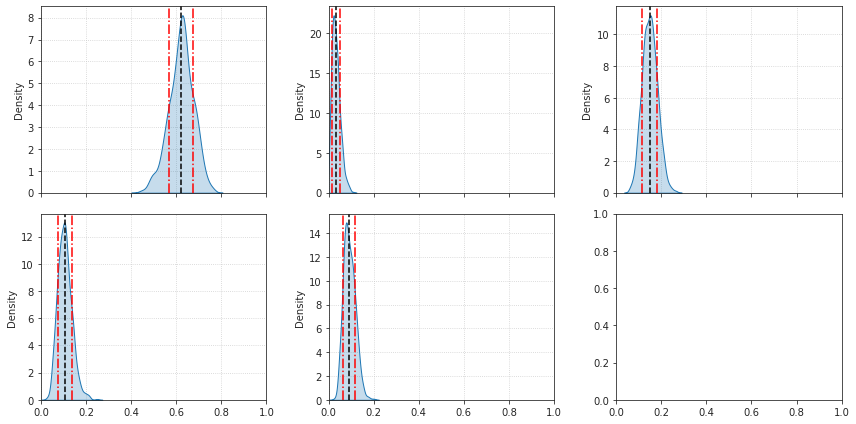

In [55]:
i, j, k = 3, 1, 2
kk = 0
nn = 13

means = []

fig, axes = create_figure(2, 3, (12, 6), 'all')
for kk in range(5):
    ax = axes.flat[kk]
    mu, sd = bn.nanmean(b_pi[:, kk, nn]), np.nanstd(b_pi[:, kk, nn], ddof=1)
    means.append(mu)

    sns.kdeplot(b_pi[:, kk, nn], fill=True, ax=ax)
    ax.axvline(mu, ls='--', color='k')
    ax.axvline(mu - sd, ls='-.', color='r')
    ax.axvline(mu + sd, ls='-.', color='r')
    ax.set_xlim(0, 1)
    ax.grid()
# trim_axs(axes, 5)
plt.show()

In [56]:
k, n = b.shape[-2:]
cut, _ = cut_data(
    data=b.reshape(-1, k, n),
    bins=gr_bold.bins,
    oc_only=True,
)
cut = cut.reshape((*b.shape[:-2], k, -1))
cut.shape

(1000, 10, 3, 4, 5, 4)

In [57]:
cut_avg = bn.nanmean(bn.nanmean(bn.nanmean(cut, 3), 2), 1)
cut_avg.shape

(1000, 5, 4)

In [58]:
np.nanmean(cut_avg, 0)

array([[26.73533513, 20.48613509, 18.2968405 , 34.48168928],
       [24.51226449, 19.97657504, 19.60514594, 35.90601453],
       [22.77329996, 16.94697754, 17.57707526, 42.70264724],
       [33.92946954, 24.35123915, 20.74500366, 20.97428765],
       [36.53444558, 22.99750141, 16.67565264, 23.79240037]])

In [59]:
gr_bold.grp_cut

memmap([[35.25878693, 24.28579604, 18.84041316, 21.61500387],
        [31.49803327, 23.17122317, 24.00660292, 21.32414064],
        [28.9771541 , 19.50553565, 19.69573704, 31.8215732 ],
        [42.91457401, 29.34498867, 20.56416208,  7.17627524],
        [45.9183388 , 23.75434539, 20.76910568,  9.55821013]])

In [60]:
np.nanstd(cut_avg, 0, ddof=1)

array([[1.71076607, 1.65939907, 1.18350936, 2.90741477],
       [1.69833158, 1.28633078, 1.46881582, 2.96761624],
       [1.61138589, 1.29342123, 1.16711916, 2.63666741],
       [1.85328411, 1.26016671, 1.25115914, 1.98255324],
       [2.36345799, 1.4741328 , 1.0180326 , 2.26742571]])